In [9]:
import numpy as np
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            #nn.BatchNorm3d(16),
            nn.LeakyReLU(0.3),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.LeakyReLU(0.3),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.LeakyReLU(0.3))
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.LeakyReLU(0.3),
                                        nn.Linear(32, 8),
                                        nn.LeakyReLU(0.3),
                                        nn.Linear(8, 1))
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        # print("conv1", x.shape)
        x = self.conv2(x)
        # print("conv2", x.shape)
        x = self.conv3(x)
        # print("conv3", x.shape)
        x = self.regressor(x)
        return x

In [5]:
df = pd.read_pickle("data/all_221_cp5_3_species_oxides.pkl")
df = drop_duplicates(df)
df

Number of molecules 1983


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:b778fabdb1b01db1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAlO/T00...,Ag1Al1O3,"[1, 1, 3]","[Ag, Al, O]",5,221,cP5,"[3.7688035, 3.7688035, 3.7688035, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.8844, 1.8844, 1.8844], [0...",-5.04863,-0.775736
2,aflow:272cd0e74db84a51,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAsO/T00...,Ag1As1O3,"[1, 1, 3]","[Ag, As, O]",5,221,cP5,"[3.7951634, 3.7951634, 3.7951634, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.89758, 1.89758, 1.89758],...",-4.55519,-0.100528
4,aflow:7e6bdbc495310b44,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAuO/T00...,Ag1Au1O3,"[1, 1, 3]","[Ag, Au, O]",5,221,cP5,"[4.1003175, 4.1003175, 4.1003175, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [2.05016, 2.05016, 2.05016],...",-2.80408,1.37453
6,aflow:c0e1c25976bb4c75,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgB_hO/T0...,Ag1B1O3,"[1, 1, 3]","[Ag, B, O]",5,221,cP5,"[3.484261, 3.484261, 3.484261, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.74213, 1.74213, 1.74213],...",-4.55549,0.30734
8,aflow:3b79b8b28a5d5cc1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgBa_svO/...,Ag1Ba1O3,"[1, 1, 3]","[Ag, Ba, O]",5,221,cP5,"[4.7271734, 4.7271734, 4.7271734, 90.0, 90.0, ...","[[-0.0, 0.0, -0.0], [0.5, 0.5, 0.5], [-0.0, 0....","[[-0.0, 0.0, -0.0], [2.36359, 2.36359, 2.36359...",-3.52096,0.388015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,aflow:e243d024b0749ac0,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZn/T00...,O3Xe1Zn1,"[3, 1, 1]","[O, Xe, Zn]",5,221,cP5,"[4.370543, 4.370543, 4.370543, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.18527, 2.18527], [2.18527, 0.0, 2.185...",-1.89960,None
3949,aflow:ae4a07b2d68c2933,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZr_sv/...,O3Xe1Zr1,"[3, 1, 1]","[O, Xe, Zr]",5,221,cP5,"[4.322477, 4.322477, 4.322477, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[-0.0, 2.16124, 2.16124], [2.16124, -0.0, 2.1...",-5.89112,-1.222
3951,aflow:0d9d3ce033a32aae,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZn/T...,O3Y1Zn1,"[3, 1, 1]","[O, Y, Zn]",5,221,cP5,"[4.3517566, 4.3517566, 4.3517566, 90.0, 90.0, ...","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.17588, 2.17588], [2.17588, 0.0, 2.175...",-5.57716,-1.07268
3953,aflow:627232532ed2fb40,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZr_s...,O3Y1Zr1,"[3, 1, 1]","[O, Y, Zr]",5,221,cP5,"[4.155165, 4.155165, 4.155165, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.07758, 2.07758], [2.07758, 0.0, 2.077...",-8.70129,-2.74124


In [6]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(79,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
        'Fe', 'Ga', 'Gd', 'Ge', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir', 'K',
        'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni',
        'O', 'Os', 'P', 'Pa', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb', 'Re',
        'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Tb',
        'Tc', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Xe', 'Y', 'Yb', 'Zn',
        'Zr'], dtype='<U2'))

In [7]:
net = VoxelNet(nchannel)
count_parameters(net)

81073

(1784, 13) (199, 13)
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 14.604804992675781 val loss 3.556546211242676
Epoch 1: train loss 2.590949058532715 val loss 2.377230167388916
Epoch 2: train loss 2.2342586517333984 val loss 2.393793821334839
Epoch 3: train loss 2.1590535640716553 val loss 2.4100029468536377
Epoch 4: train loss 2.180845260620117 val loss 2.346633195877075
Epoch 5: train loss 2.173525333404541 val loss 2.371260404586792
Epoch 6: train loss 2.127218723297119 val loss 2.3700528144836426
Epoch 7: train loss 2.1224238872528076 val loss 2.367182970046997
Epoch 8: train loss 2.1395576000213623 val loss 2.331124782562256
Epoch 9: train loss 2.1020760536193848 val loss 2.3681702613830566
Epoch 10: train loss 2.128772497177124 val loss 2.2986319065093994
Epoch 11

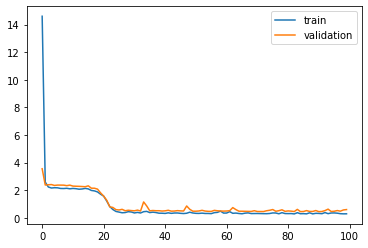

In [8]:
sigma = 0.5
L = 12.8
N = 32
epochs = 100
device = get_default_device()


seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True)

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True)

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0.01)

### Train Plots

Initialised MolLoader with 1784 molecules. sigma = 0.5, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda


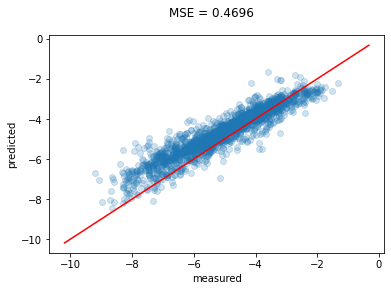

In [11]:
ml_pred = MolLoader(train_df, sigma=sigma, elements=elements,
                   L=L, N=N, batch_size=128, nchannel=nchannel,
                   shuffle=False, rotate_randomly=False, device=device)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

In [ ]:
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)

### Test Plots

In [ ]:
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

In [ ]:
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)